In [1]:
import xgboost as xgb
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math

In [2]:
## Step 1: Import CSV files
trainX = pd.read_csv('trainX.csv')
trainY = pd.read_csv('trainY.csv')
testX = pd.read_csv('testX.csv')
testY = pd.read_csv('testY.csv')

In [3]:
## Step 2: Check for any Null or NaN
headers = trainX.mean().to_dict()

# for i in headers:
#     headers[i] = 0

trainX = trainX.fillna(headers)
trainX = trainX.fillna('None')

testX = testX.fillna(headers)
testX = testX.fillna('None')

# na = trainX.isna().any()

# for i, val in na.iteritems():
#     if (val == True):
#         print(i)

In [4]:
## Step 3: Convert any non-numerical input features into one hot encoding
#number of train
num_of_train = trainX.shape[0]
num_of_test = testX.shape[0]

#Combine training and test data
all_data = pd.concat([trainX, testX], sort=False).reset_index(drop=True)

#Getting dummy categorical values
all_data = pd.get_dummies(all_data)
print('Number of features: %d' %all_data.shape[1])

#Seperate Training and Testing data
trainX = all_data.iloc[:num_of_train,:]
testX = all_data.iloc[num_of_train:,:]

print('Number of train rows: %d' %trainX.shape[0])
print('Number of test rows: %d' %testX.shape[0])

# trainX = pd.get_dummies(trainX)
# testX = pd.get_dummies(testX)

Number of features: 303
Number of train rows: 1022
Number of test rows: 438


In [5]:
## Step 4: Normal Distribution all input features
trainX = (trainX - np.mean(trainX, axis=0)) / np.std(trainX, axis=0)
testX = (testX - np.mean(testX, axis=0)) / np.std(testX, axis=0)

In [6]:
## Step 5: Scale all targets (/1000)
# trainY /= 1000
# testY /= 1000

In [7]:
## Step 6: Get correlation matrix
def getCorrMat(k):
    train = pd.concat([trainX, trainY], sort=False, axis=1)
    corrMatrix = train.corr()

    cols = corrMatrix.nlargest(k+1, 'SalePrice')['SalePrice'].index

    f, ax = plt.subplots(figsize=(14, 10))
    sns.heatmap(train[cols].corr(), vmax=.8, square=True, annot=True)
    plt.title('Features: %d' %k)
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.autoscale()
#     plt.savefig('corrmat_%d' %k, dpi=300)
    plt.show()
    
    return cols

In [8]:
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

def evaluate(xgbr, trainX_, testX_):
    testY_ = testY['SalePrice'].values
    ypred = xgbr.predict(testX_)

    scores = cross_val_score(xgbr, trainX_, trainY, cv=5)
    print("Mean cross-validation score: %.5f" % scores.mean())

    kfold = KFold(n_splits=10, shuffle=True)
    kf_cv_scores = cross_val_score(xgbr, trainX_, trainY, cv=kfold)
    print("K-fold CV average score: %.5f" % kf_cv_scores.mean())
    print()

    mse = mean_squared_error(testY_, ypred)
    print("Mean Square Error: %.5f" % mse)
    msep = 0
    print("Mean Square Error (%%): {:.5f}".format(msep))
    print()
    
    print("Root Mean Square Error: %.5f" % np.sqrt(mse))
    rmsle_ = rmsle(testY_, ypred)
    print("Root Mean Square Log Error: %.5f" %rmsle_)
    print()

    mae = np.mean(np.abs(testY_ - ypred))
    print("Mean Absolute Error: {:.5f}".format(mae))
    maep = np.mean(np.abs((testY_ - ypred) / testY_)) * 100
    print("Mean Absolute Error (%%): %.5f%%" % maep)
    
    return ypred, rmsle_

In [9]:
## Plot figures
def plotResults(ypred, k, rmsle_):
    x_ax = range(len(testY))
    plt.figure(1, figsize=(10, 7))
    plt.title('Features: %d, RMSLE: %.5f' %(k, rmsle_))
    plt.scatter(x_ax, testY, s=5, color="blue", label="Original")
    plt.plot(x_ax, ypred, lw=0.8, color="red", label="Predicted")
    plt.xlabel('Test Dataset')
    plt.ylabel('SalePrice')
    plt.legend()
    plt.autoscale()
#     plt.savefig('XGBoost_Versus_%d' %k, dpi=300)

    plt.figure(2, figsize=(10, 7))
    plt.title('Features: %d, RMSLE: %.5f' %(k, rmsle_))
    plt.scatter(ypred, testY, s=5, color="blue")
    plt.plot([testY.min(), testY.max()],[testY.min(), testY.max()], 'k--', lw=2)
    plt.xlabel('Predicted')
    plt.ylabel('Original')
#     plt.savefig('XGBoost_Scatter_%d' %k, dpi=300)
    plt.show()

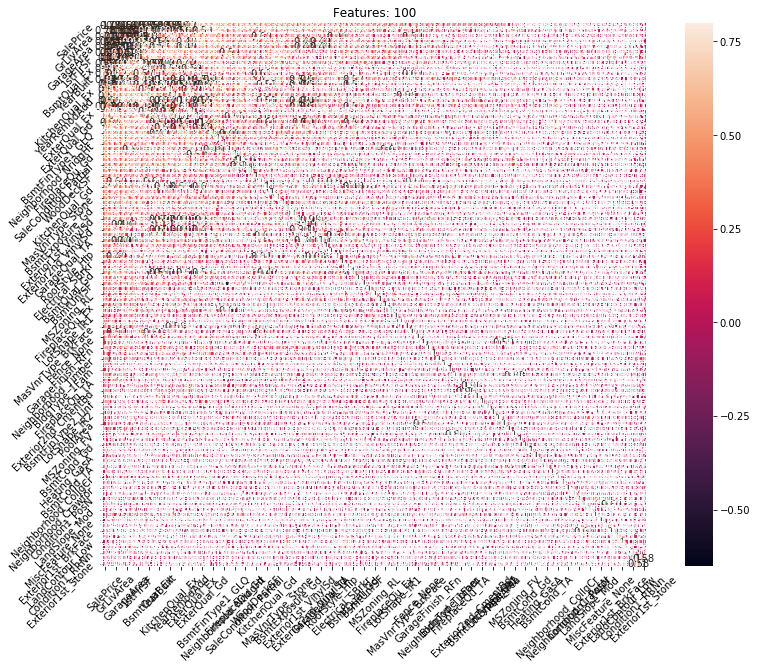

Mean cross-validation score: 0.87084
K-fold CV average score: 0.86483

Mean Square Error: 649679812.28173


TypeError: unsupported format string passed to numpy.ndarray.__format__

In [10]:
## Main Program
features = [100] #5, 10, 25, 50, 75, 100, 150, 200, 250, 300

for f in features:
    # Create the model
    xgbr = xgb.XGBRegressor(objective='reg:squarederror')
    
    cols = getCorrMat(f)
    
    # Use only top f correlated features
    trainX_ = trainX[cols[1:]]
    testX_ = testX[cols[1:]]
    
    # Train the model
    xgbr.fit(trainX_, trainY)

    # Evaluate with test dataset
    ypred, rmsle_ = evaluate(xgbr, trainX_, testX_)
    plotResults(ypred, f, rmsle_)